Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data - read the data

In [65]:
import pathlib
import os
import PIL

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


In [66]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

#Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Data Reading/Data Understanding

In [67]:
## Todo: Update the paths of the train and test dataset

# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [68]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
# 2239

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
# 118

2239
118


### Load using keras.preprocessing

Load images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [69]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [70]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [72]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [73]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,               # Path to test dataset
    image_size=(img_height, img_width),  # Resize images to match training size
    batch_size=batch_size,       # Keep batch size same as training
    shuffle=False                # No shuffling for test data
)

Found 118 files belonging to 9 classes.


### List out all the classes

In [74]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

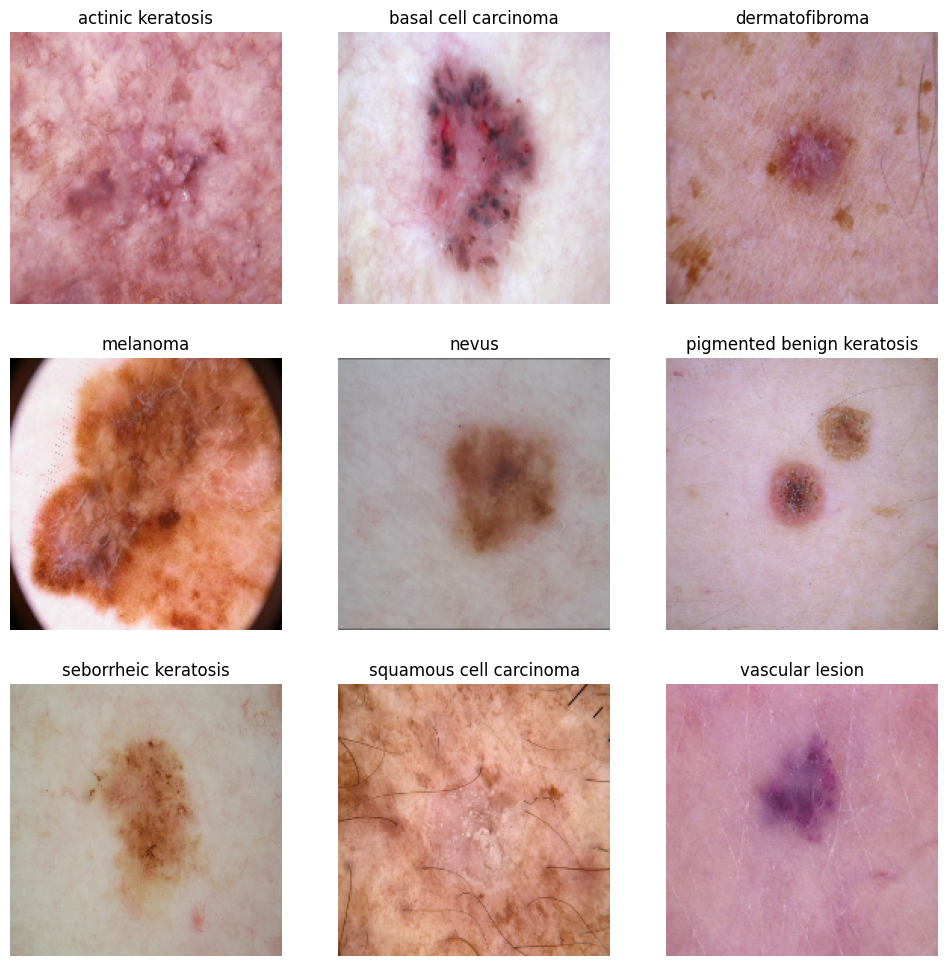

In [76]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

import numpy as np

plt.figure(figsize=(12, 12))

for i, class_name in enumerate(class_names):
    # Search for an image with the target label in the first few batches
    for batch_index in range(10):
        for images, labels in train_ds.take(1):
            # Find indices where label matches current class
            indices = np.where(labels.numpy() == i)[0]
            if indices.size > 0:
                idx = indices[0]  # Select the first matching index
                plt.subplot(3, 3, i + 1)
                plt.imshow(images[idx].numpy().astype("uint8"))
                plt.title(class_name)
                plt.axis("off")
                break  # Exit if image found
        else:
            continue  # Next batch - if no image found
        break

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [77]:
# check the shape of the image and label
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - Model Building & training - Model 1
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Model 1 - Only convolution, scaling, pooling

In [80]:
### Your code goes here

from tensorflow.keras import layers, models

model_original = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
### Todo, choose an appropirate optimiser and loss function
model_original.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [82]:
# View the summary of all layers
model_original.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history_original = model_original.fit(
    train_ds,                   # Training dataset
    epochs=20,                  # Number of times dataset is passed
    validation_data=val_ds     # Validation dataset
)
### Inference
## Check for overfitting and underfitting
## Overfitting: High accuracy on training but low accuracy on validation.
## Underfitting: Low accuracy on both datasets indicates insufficient learning.

# Epoch 20: accuracy: 0.8263 - loss: 0.4426 - val_accuracy: 0.4653 - val_loss: 2.3840
# This is case of Overfitting

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 125ms/step - accuracy: 0.2030 - loss: 2.2951 - val_accuracy: 0.2550 - val_loss: 1.9067
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.3277 - loss: 1.8028 - val_accuracy: 0.4318 - val_loss: 1.5878
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4485 - loss: 1.5512 - val_accuracy: 0.4855 - val_loss: 1.4755
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4681 - loss: 1.4966 - val_accuracy: 0.5078 - val_loss: 1.4792
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5224 - loss: 1.3582 - val_accuracy: 0.4832 - val_loss: 1.4613
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5452 - loss: 1.3029 - val_accuracy: 0.5503 - val_loss: 1.3809
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5761 - loss: 1.2429 - val_accuracy: 0.5414 - val_loss: 1.3884
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6061 - loss: 1.1056 - val_accuracy: 0.5570 

### Visualize Metrics - Model 1

In [84]:
# Create plots of the loss and accuracy on the training and validation sets:
def plot_performance_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # epochs_range = range(epochs)
    epochs_range = range(len(acc))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

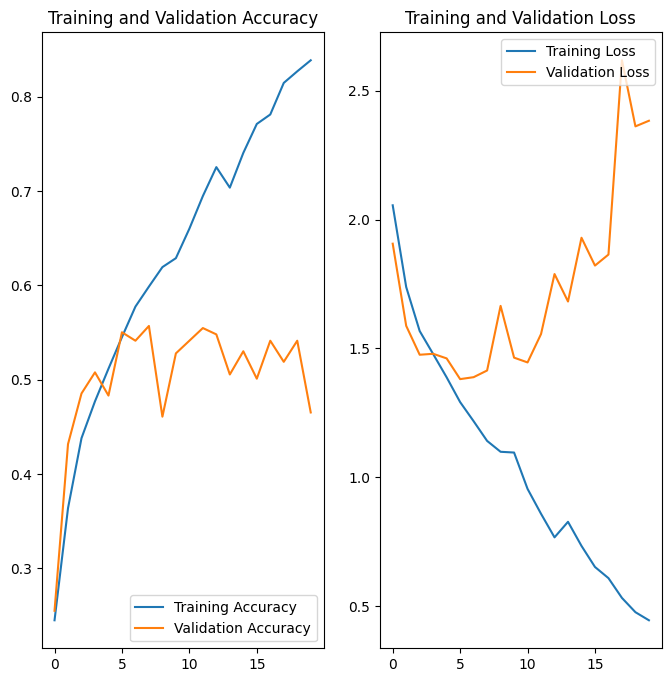

In [85]:
# Visualizing training results
epochs = 20
plot_performance_metrics(history_original,epochs)

# Identifying Overfitting:

# High training accuracy, low validation accuracy.
# Low training loss, high validation loss.
# Identifying Underfitting:

# Low accuracy for both training and validation.
# High loss for both training and validation.
# Optimal Model Selection:

# Pick the model state at the epoch with the best validation performance.
# Train and validation data(Accuracy and Loss) suggest overfitting and need for improved model.

### Source data set distribution

In [86]:
## Your code goes here.
# get the count of images in each of the class.

for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    # print(f'{directory} is directory')
    # print(f'{class_directory} is class directory')
    print(f'{i} has {length} samples.')

# Below data shows the count of images in each class and imbalance problem
# melanoma and pigmented benign keratosishas higher representation
# dermatofibroma and seborrheic keratosis has less representation

# actinic keratosis has 114 samples.
# basal cell carcinoma has 376 samples.
# dermatofibroma has 95 samples.
# melanoma has 438 samples.
# nevus has 357 samples.
# pigmented benign keratosis has 462 samples.
# seborrheic keratosis has 77 samples.
# squamous cell carcinoma has 189 samples.
# vascular lesion has 139 samples.

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


In [87]:
import collections

labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
class_counts = dict(collections.Counter(labels))

print("Class Distribution:", class_counts)
least_common = min(class_counts, key=class_counts.get)
most_common = max(class_counts, key=class_counts.get)

print(f"Least Represented Class: {class_names[int(least_common)]}")
print(f"Most Represented Class: {class_names[int(most_common)]}")

Class Distribution: {np.int32(3): 352, np.int32(1): 309, np.int32(4): 277, np.int32(2): 77, np.int32(8): 115, np.int32(5): 370, np.int32(0): 92, np.int32(7): 142, np.int32(6): 58}
Least Represented Class: seborrheic keratosis
Most Represented Class: pigmented benign keratosis


### Data augmentation(keras)

In [88]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

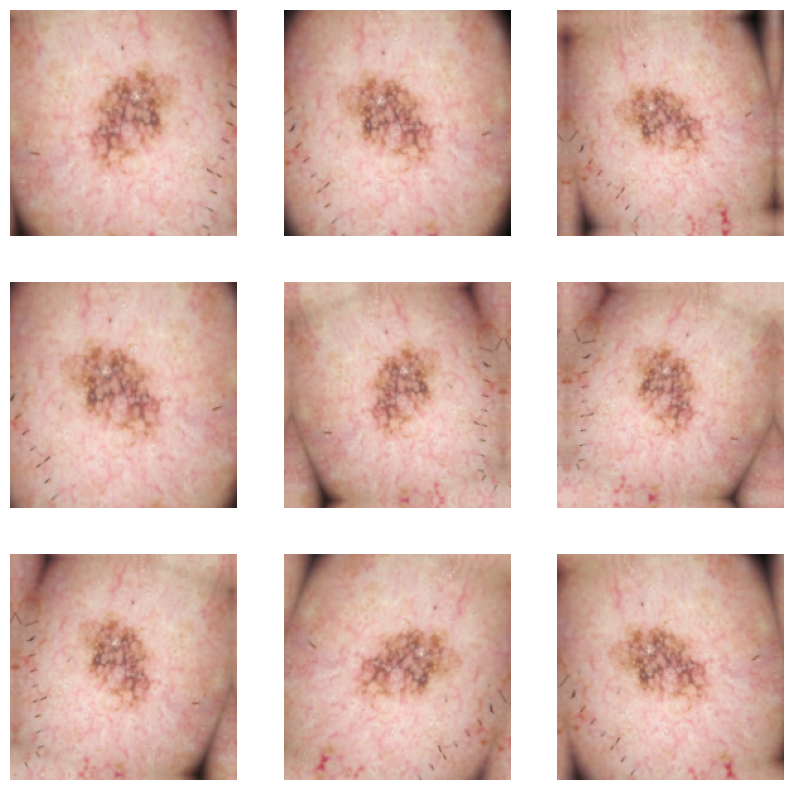

In [89]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model - Model Building & training - Model 2 (Keras augmentation without dropping)

In [90]:
model_aug_no_drop = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # adding the augmentation layer before the convolution layer
    data_augmentation,
    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [91]:
# Compiling the model
model_aug_no_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_aug_no_drop.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,203,017 (50.37 MB)

 Trainable params: 13,203,017 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Training the model
epochs = 20
history_aug_no_drop = model_aug_no_drop.fit(train_ds,validation_data=val_ds,epochs=epochs)

# Epoch 20 - accuracy: 0.5918 - loss: 1.1712 - val_accuracy: 0.5705 - val_loss: 1.3521
# Gap between training and validation - Accuracy and Loss got reduced but need further improvement

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.1897 - loss: 2.2252 - val_accuracy: 0.3177 - val_loss: 1.8230
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3791 - loss: 1.7150 - val_accuracy: 0.4295 - val_loss: 1.6483
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4515 - loss: 1.5224 - val_accuracy: 0.4966 - val_loss: 1.5042
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5131 - loss: 1.3811 - val_accuracy: 0.5034 - val_loss: 1.3946
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5395 - loss: 1.3385 - val_accuracy: 0.5123 - val_loss: 1.4411
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5445 - loss: 1.3237 - val_accuracy: 0.5414 - val_loss: 1.3130
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5489 - loss: 1.2767 - val_accuracy: 0.5034 - val_loss: 1.3719
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5553 - loss: 1.2742 - val_accuracy: 0.5436 - v

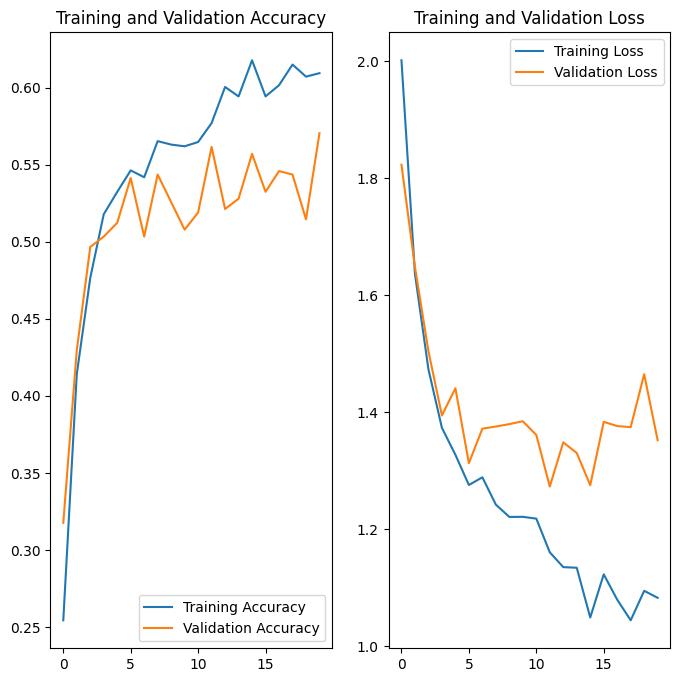

In [94]:
# Visualizing training results
plot_performance_metrics(history_aug_no_drop,epochs)

### Create the model - Model Building & training - Model 3 (Apply dropouts with keras augmentation)

In [95]:
model_aug_with_drop = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # adding the augmentation layer before the convolution layer
    data_augmentation,
    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    #adding a 20% dropout after the convolution layers
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [96]:
# Compiling the model
model_aug_with_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_aug_with_drop.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,203,017 (50.37 MB)

 Trainable params: 13,203,017 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Training the model
epochs = 20
history = model_aug_with_drop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Epoch 20 - accuracy: 0.6048 - loss: 1.0638 - val_accuracy: 0.5570 - val_loss: 1.4023
# Both Training and validation accuracy dropped and not very high.
# Need to use Augmentor to balance the data with additional images

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.2529 - loss: 2.1291 - val_accuracy: 0.3400 - val_loss: 1.7930
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3629 - loss: 1.7219 - val_accuracy: 0.4609 - val_loss: 1.5178
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4431 - loss: 1.5293 - val_accuracy: 0.5190 - val_loss: 1.4509
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5049 - loss: 1.4691 - val_accuracy: 0.5257 - val_loss: 1.4011
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5340 - loss: 1.3765 - val_accuracy: 0.5168 - val_loss: 1.5301
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5333 - loss: 1.3511 - val_accuracy: 0.4944 - val_loss: 1.4705
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5238 - loss: 1.3091 - val_accuracy: 0.5302 - val_loss: 1.4187
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5556 - loss: 1.2386 - val_accuracy: 0.4541 - v

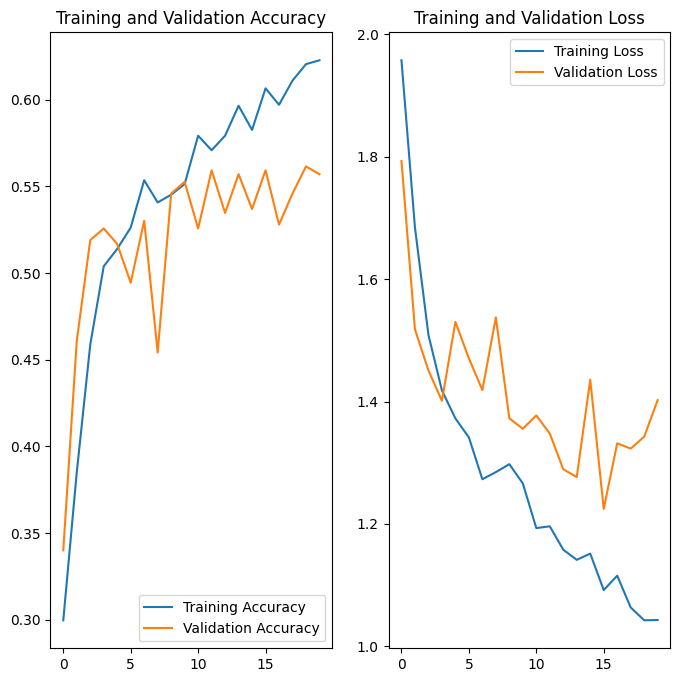

In [98]:
# Visualizing training results - after dropouts
plot_performance_metrics(history,epochs)

### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [100]:
!pip install Augmentor

In [101]:
path_to_training_dataset=str(data_dir_train) + '/'

In [30]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

# class_names contains the different classes of images (e.g., melanoma, nevus, etc.).
# Augmentor.Pipeline() initializes an augmentation pipeline for each class directory.
# rotate() applies a rotation to images with: 70% probability (probability=0.7), Random rotation from -10 to +10 degrees.
# sample(500) generates 500 augmented images per class to balance the dataset.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B3CC290810>: 100%|██████████| 500/500 [00:18<00:00, 27.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B3CC62A9D0>: 100%|██████████| 500/500 [00:19<00:00, 26.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79B3CC251650>: 100%|██████████| 500/500 [00:19<00:00, 26.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x79B3CC2FFDD0>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1008x711 at 0x79B3CC2C5050>: 100%|██████████| 500/500 [01:19<00:00,  6.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79B3CC3C48D0>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79B3CC2C5B90>: 100%|██████████| 500/500 [00:40<00:00, 12.36 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B3CC1F8A10>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B3CC201D90>: 100%|██████████| 500/500 [00:19<00:00, 25.48 Samples/s]


In [106]:
# data_dir_train.glob() finds all .jpg images within output folders.
# len() prints the total number of training images after augmentation.

import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)
# total images generated = 4500 = 9 classes * 500 images each



4500


In [107]:
# Generates a list of paths for all augmented images.
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_04f3857b-60fc-4659-9b0b-da9909b7ae7c.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_bef08312-7354-4118-ae53-8f48078236cf.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_c19d2268-477f-4a97-9885-f88137f37678.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_5eac811c-7be0-4876-b8ae-6b273d27cf06.jpg',
 '/content/drive/MyDrive/Melanoma Assign

In [33]:
# Extracts the class name (e.g., melanoma, nevus) from the parent directory.
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
# Create a dictionary that contains the path and the label for each of the image generated in output folder.
# Keys -> Image paths
# Values-> Corresponding class labels

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

### Augmented Data Distribution

In [35]:
for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    directory_out =str(data_dir_train)+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

# Number of overall samples has increased after Augmentation

# actinic keratosis has 614 samples.
# basal cell carcinoma has 876 samples.
# dermatofibroma has 595 samples.
# melanoma has 938 samples.
# nevus has 857 samples.
# pigmented benign keratosis has 962 samples.
# seborrheic keratosis has 577 samples.
# squamous cell carcinoma has 681 samples.
# vascular lesion has 639 samples.

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


In [36]:
path_list_orig = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_orig

['/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg',
 '/content/drive/MyDrive/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg',
 '/content

In [38]:
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_orig

['Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',


In [39]:
original_dict = dict(zip(path_list_orig, lesion_list_orig))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
1,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
2,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
3,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
4,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train


In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [41]:
new_df['Label'].value_counts()

,count
Label,
Train,2239
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500


In [42]:
# we have added images to all the classes to maintain some class balance. We can add more images if we want to improve training process.
new_df.head()

,Path,Label
0,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
1,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
2,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
3,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train
4,/content/drive/MyDrive/Melanoma Assignment/CNN...,Train


In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Found 6739 files belonging to 9 classes.
# Using 5392 files for training.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Found 6739 files belonging to 9 classes.
# Using 1347 files for validation.

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create the model - Model Building & training - Model 4 (Using Original + Generated images(by Augmentor) for training and validation without dropout and 30 epoch)

In [45]:
model_augmentor = models.Sequential([
    # scaling the pixel values from 0-255 to 0-1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
# Compiling the model
model_augmentor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_augmentor.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
epochs = 30
history_augmentor = model_augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# On 29th Epoch, Training and Validation accuracy is close but 30th epoch resulted in gap.
# Check further with use of Dropouts, Batch normalization, callbacks and early stopping
# Epoch 29/30
# 169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.9546 - loss: 0.1070 - val_accuracy: 0.8048 - val_loss: 0.9563
# Epoch 30/30
# 169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9518 - loss: 0.1076 - val_accuracy: 0.7966 - val_loss: 0.9217

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - accuracy: 0.2088 - loss: 2.3129 - val_accuracy: 0.4388 - val_loss: 1.4799
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - accuracy: 0.4532 - loss: 1.4695 - val_accuracy: 0.4929 - val_loss: 1.3843
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 275ms/step - accuracy: 0.5651 - loss: 1.2128 - val_accuracy: 0.6036 - val_loss: 1.0770
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 286ms/step - accuracy: 0.6328 - loss: 0.9941 - val_accuracy: 0.6088 - val_loss: 1.0396
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.7045 - loss: 0.8131 - val_accuracy: 0.6147 - val_loss: 1.0675
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - accuracy: 0.7681 - loss: 0.6518 - val_accuracy: 0.7216 - val_loss: 0.8378
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - accuracy: 0.8258 - loss: 0.5007 - val_accuracy: 0.7216 - val_loss: 0.8908
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 227ms/step - accuracy: 0.8553 - loss: 0

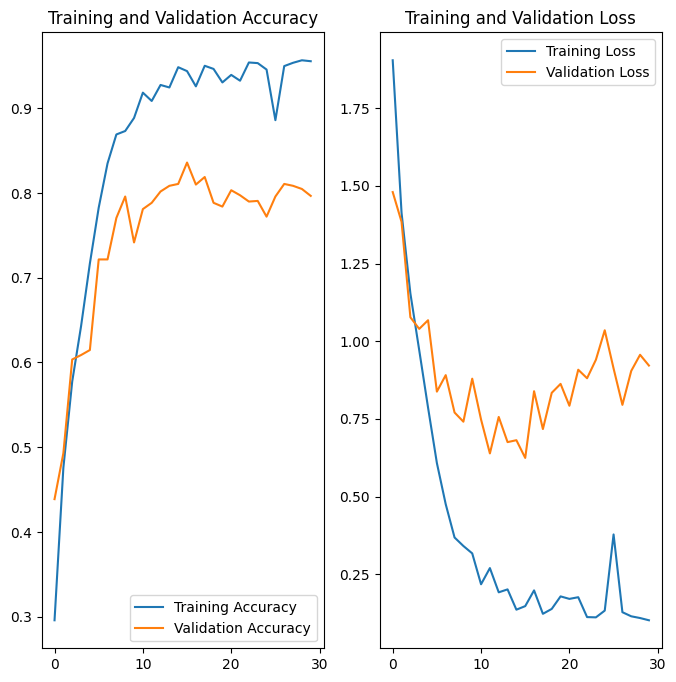

In [ ]:
# Visualizing model results
plot_performance_metrics(history_augmentor,epochs)

### Create the model - Model Building & training - Model 5(Using Original + Generated images(by Augmentor), Dropouts for training and validation and 30 epoch)

In [48]:
model_aug_with_dropout = models.Sequential([
    # scaling the pixel values from 0-255 to 0-1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    #adding a 20% dropout after the convolution layers
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# Compiling the model
model_aug_with_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_aug_with_dropout.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Training the model with 30 epoch, 50 epoch is compute intensive operation and time consuming.
epochs = 30
history_bn_dropout = model_aug_with_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Train and validation accuracy has increased
# Epoch 29/30
# 169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.9375 - loss: 0.1644 - val_accuracy: 0.7958 - val_loss: 0.9675
# Epoch 30/30
# 169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9509 - loss: 0.1274 - val_accuracy: 0.7728 - val_loss: 1.0591

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - accuracy: 0.2570 - loss: 1.9694 - val_accuracy: 0.4202 - val_loss: 1.4429
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 225ms/step - accuracy: 0.4592 - loss: 1.4175 - val_accuracy: 0.5360 - val_loss: 1.2844
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 256ms/step - accuracy: 0.5328 - loss: 1.2432 - val_accuracy: 0.5323 - val_loss: 1.2987
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.6304 - loss: 1.0125 - val_accuracy: 0.6080 - val_loss: 1.0998
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.6952 - loss: 0.8366 - val_accuracy: 0.6622 - val_loss: 1.0134
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.7536 - loss: 0.6991 - val_accuracy: 0.6897 - val_loss: 0.9369
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - accuracy: 0.7772 - loss: 0.6356 - val_accuracy: 0.7246 - val_loss: 0.8763
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.8281 - loss: 0

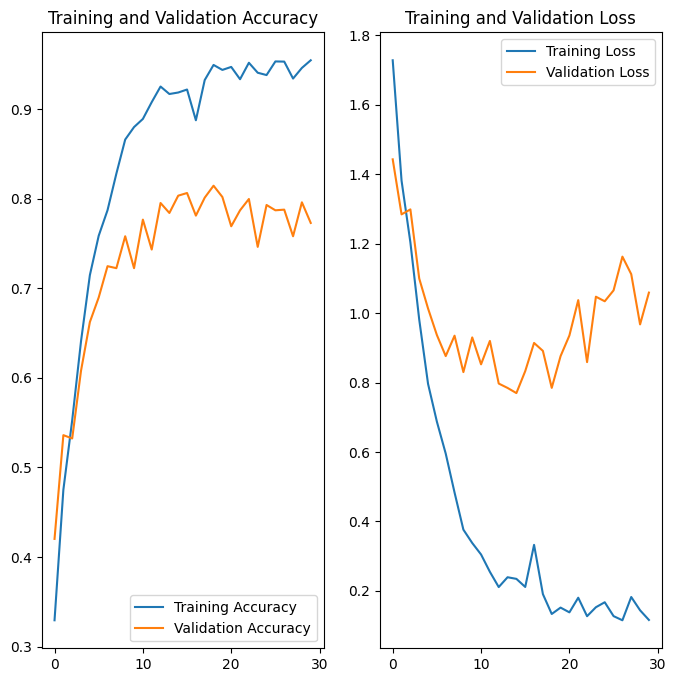

In [51]:
# Visualizing model results
plot_performance_metrics(history_bn_dropout,epochs)

In [52]:
# evaluate the model on test data
# model.evaluate(x_test, y_test)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_loss, test_accuracy = model_aug_with_dropout.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.3718 - loss: 6.9730
Test Accuracy: 36.44%
Test Loss: 7.0955


### Create the model - Model Building & training - Model 6 (Using Original + Generated images(by Augmentor), Batch Normalization, Dropouts for training and validation and 30 epoch)

In [53]:
model_bn_dropout = models.Sequential([
    # Scaling the pixel values from 0-255 to 0-1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolution layer with 32 filters, 3x3 kernel, ReLU activation, 2x2 pooling
    layers.Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 64 filters, 3x3 kernel, ReLU activation, 2x2 pooling
    layers.Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Convolution layer with 128 filters, 3x3 kernel, ReLU activation, 2x2 pooling
    layers.Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Adding 20% dropout after convolution layers
    layers.Dropout(0.2),
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(128),
    BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(len(class_names), activation='softmax')
])


In [54]:
# Compiling the model
model_bn_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_bn_dropout.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience= 5,
    restore_best_weights=True
)

# Training the model with 30 epoch, 50 epoch is compute intensive operation and time consuming.
epochs = 30
history_bn_dropout = model_bn_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  # ,callbacks=[early_stopping]
)



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 8,025,801 (30.62 MB)

 Trainable params: 8,025,097 (30.61 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 250ms/step - accuracy: 0.4324 - loss: 1.6066 - val_accuracy: 0.1151 - val_loss: 2.9310
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 227ms/step - accuracy: 0.6462 - loss: 0.9702 - val_accuracy: 0.1856 - val_loss: 2.5137
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.7757 - loss: 0.6603 - val_accuracy: 0.4766 - val_loss: 1.3225
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 252ms/step - accuracy: 0.8502 - loss: 0.4611 - val_accuracy: 0.6347 - val_loss: 0.9658
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy: 0.8985 - loss: 0.3172 - val_accuracy: 0.6919 - val_loss: 0.8886
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9068 - loss: 0.2720 - val_accuracy: 0.7186 - val_loss: 0.7629
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.9247 - loss: 0.2208 - val_accuracy: 0.4870 - val_loss: 1.4194
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step - accuracy: 0.9353 - loss: 0

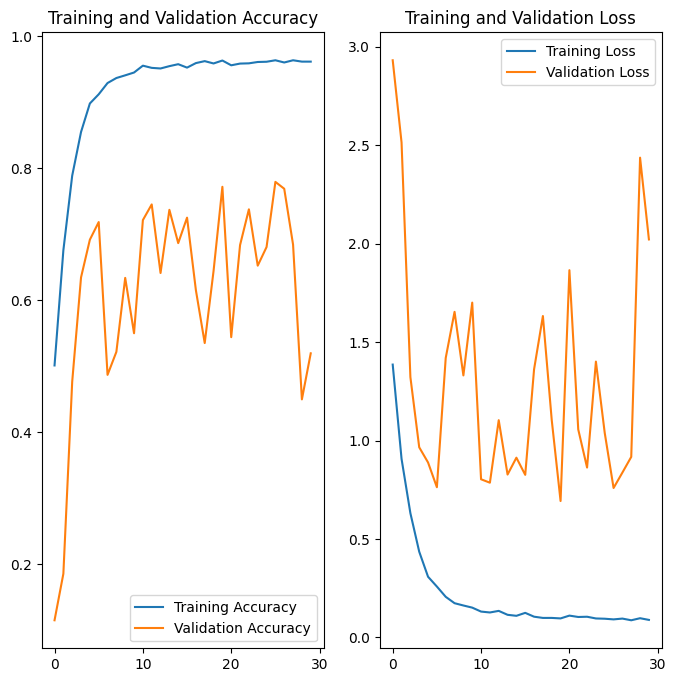

In [55]:
# Visualizing model results
plot_performance_metrics(history_bn_dropout,epochs)

# Epoch 29/30
# 169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.9569 - loss: 0.1024 - val_accuracy: 0.4499 - val_loss: 2.4365
# Epoch 30/30
# 169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.9563 - loss: 0.1000 - val_accuracy: 0.5197 - val_loss: 2.0212

# This is again over fitting
# Gap between training and validation - got wider than before(without using Batch normalization and dropouts)
# Use of callback terminated the model much before and expected accuracies were not met.

# Test results indicate further drop in accuracy and increase in loss
# Test Accuracy: 23.73%
# Test Loss: 5.5959

Evaluating Model 6

In [58]:
# evaluate the model on test data
# model.evaluate(x_test, y_test)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_loss, test_accuracy = model_bn_dropout.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2480 - loss: 5.8403
Test Accuracy: 23.73%
Test Loss: 5.5959


In [59]:
print(model_bn_dropout.metrics_names)

['loss', 'compile_metrics']


### Create the model - Model Building & training -Model 7 (Using Original + Generated images(by Augmentor), Batch Normalization, Dropouts along with EarlyStopping to control validation loss for training and validation and 30 epoch)

In [109]:
model_bn_nobias_dropout = models.Sequential([
    # Scaling pixel values from 0-255 to 0-1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Conv Layer 1
    layers.Conv2D(32, (3,3), use_bias=False),  # Remove bias when using BN
    BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Conv Layer 2
    layers.Conv2D(64, (3,3), use_bias=False),
    BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Conv Layer 3
    layers.Conv2D(128, (3,3), use_bias=False),
    BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Adding a 20% dropout after convolution layers
    layers.Dropout(0.2),

    # Fully Connected Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [110]:
# Compiling the model
model_bn_nobias_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_bn_nobias_dropout.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience= 5,
    restore_best_weights=True
)

# Training the model with 30 epoch
epochs = 30
history_bn_nobias_dropout = model_bn_nobias_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  ,callbacks=[early_stopping]
)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 178, 178, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 87, 87, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 41, 41, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,809 (25.36 MB)

 Trainable params: 6,648,361 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.2549 - loss: 12.0469 - val_accuracy: 0.2058 - val_loss: 2.1938
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3499 - loss: 1.9483 - val_accuracy: 0.2058 - val_loss: 2.1837
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3329 - loss: 1.8701 - val_accuracy: 0.2058 - val_loss: 2.1746
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3730 - loss: 1.8091 - val_accuracy: 0.2058 - val_loss: 2.1670
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3640 - loss: 1.7439 - val_accuracy: 0.2081 - val_loss: 2.1588
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3608 - loss: 1.7767 - val_accuracy: 0.2081 - val_loss: 2.1504
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3756 - loss: 1.7193 - val_accuracy: 0.2394 - val_loss: 2.0877
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3777 - loss: 1.6876 - val_accuracy: 0.3423 -

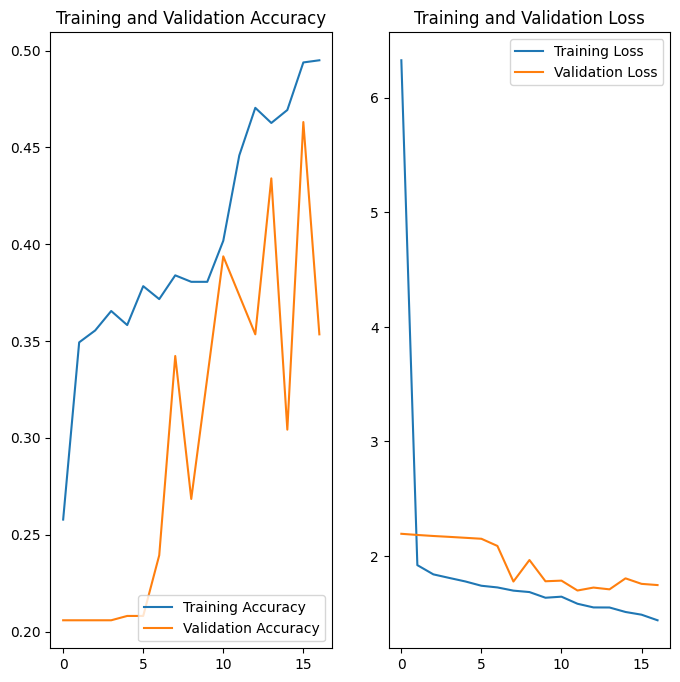

In [111]:
# Visualizing model results
plot_performance_metrics(history_bn_nobias_dropout,epochs)

### Conclusions

In [ ]:
# FINDINGS

# Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
# Yes, with Augmenter, training and validation accuracy got significantly improved.
# In notebook, the best performing model is Model 5(names as model_aug_with_dropout), which utilizes augmented images with dropout.
# It uses 6739 files belonging to 9 classes are present. It uses 5392 for training and 1347 files for validation.


# *******************************************************************
# Original data uses 2239 files in training t=dataset belonging to 9 classes.
# Uses 1792 files for training and 447 files for validation.

# melanoma and pigmented benign keratosishas higher representation
# dermatofibroma and seborrheic keratosis has less representation

# Class distribution for original data set
# actinic keratosis has 114 samples.
# basal cell carcinoma has 376 samples.
# dermatofibroma has 95 samples.
# melanoma has 438 samples.
# nevus has 357 samples.
# pigmented benign keratosis has 462 samples.
# seborrheic keratosis has 77 samples.
# squamous cell carcinoma has 189 samples.
# vascular lesion has 139 samples.

# Least Represented Class: seborrheic keratosis
# Most Represented Class: pigmented benign keratosis

# ********************************************************************
# Number of overall samples has increased after application of Augmentor library
# Over all 6739 samples belonging to 9 classes are present,  It uses 5392 for training and 1347 files for validation.
# actinic keratosis has 614 samples.
# basal cell carcinoma has 876 samples.
# dermatofibroma has 595 samples.
# melanoma has 938 samples.
# nevus has 857 samples.
# pigmented benign keratosis has 962 samples.
# seborrheic keratosis has 577 samples.
# squamous cell carcinoma has 681 samples.
# vascular lesion has 639 samples.

